# Training Models on ET-Data

This notebook demonstrates how to train different models on the Electricity Transformer (ET) dataset using the CAP framework. We'll cover:
1. Data Loading and Preprocessing,
2. Model Training,
3. Evaluation and Visualization,
4. Comparing Different Models

## Setup

First, let's import the necessary libraries and set up our environment.

In [1]:
import os
import sys
import yaml
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [2]:
# Add the parent directory to the path if needed
sys.path.append(os.path.abspath('/home/yeqchen/cap/cap-Data_Processing/'))

In [3]:
from cap.data.data import get_dataloaders
from cap.training import train_model, evaluate_model
from cap.models import *  # Import all available models


In [4]:
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [5]:
# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## 1. Load Configuration

In [7]:
# Load Configuration
config_path = '../cap/configs/ett_config.yaml'
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

# Print configuration
print("Configuration:")
print(f"Dataset: {config['dataset']['path']}")
print(f"Model: {config['model']['type']}")
print(f"Training: {config['training']['epochs']} epochs, {config['training']['device']}")

Configuration:
Dataset: ../dataset/ElectricityTransformer/ETTh1.csv
Model: lstm
Training: 50 epochs, cuda


In [8]:
 # You can modify the configuration here if needed
# config['model']['type'] = 'informer'  # Change model type
# config['training']['epochs'] = 20  # Change number of epochs

## 2. Data Loading and Preprocessing

Now let's load the ET-data and prepare it for training.

In [11]:
# Get dataloaders
train_loader, valid_loader, test_loader = get_dataloaders(
        path=config['dataset']['path'],
        batch_size=config['dataset']['batch_size'],
        shuffle=True,
        train_size=config['dataset']['train_size'],
        valid_size=config['dataset']['valid_size'],
        test_size=config['dataset']['test_size'],
        model_type=config['model']['type'],
        normalization=config['dataset'].get('normalization', True),
        seq_len  = config['model']['seq_len'],
        pred_len = config['model']['pred_len']
    )

In [14]:
# Get input and output dimensions from the first batch
for batch in train_loader:
    inputs, targets = batch
    input_dim = inputs.shape[-1]
    output_dim = targets.shape[-1]
    seq_len = inputs.shape[1]
    pred_len = targets.shape[1]
    break

print(f"Input dimension: {input_dim}")
print(f"Output dimension: {output_dim}")
print(f"Sequence length: {seq_len}")
print(f"Prediction length: {pred_len}")


Input dimension: 7
Output dimension: 1
Sequence length: 96
Prediction length: 24


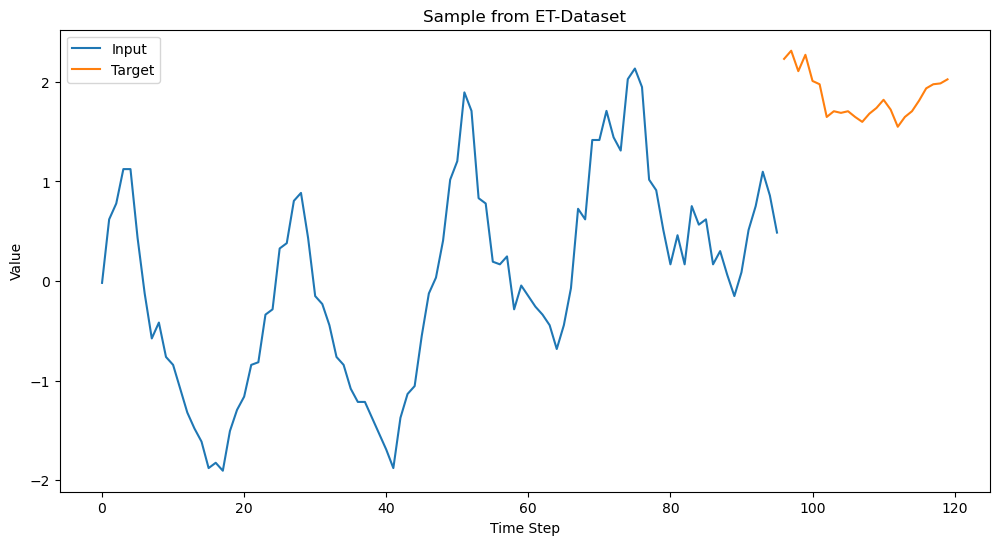

In [15]:
# Visualize a sample from the dataset
plt.figure(figsize=(12, 6))
plt.plot(inputs[0, :, 0].numpy(), label='Input')
plt.plot(range(seq_len, seq_len + pred_len), targets[0, :, 0].numpy(), label='Target')
plt.title('Sample from ET-Dataset')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()

## 3. Model Training

Let's train the model using the configuration.

In [ ]:
# Train model
model = train_model(
    train_loader=train_loader,
    valid_loader=valid_loader,
    input_dim=input_dim,
    output_dim=output_dim,
    seq_len=seq_len,
    pred_len=pred_len,
    hidden_dim=config['model']['hidden_dim'],
    num_layers=config['model']['num_layers'],
    epochs=config['training']['epochs'],
    lr=config['training']['learning_rate'],
    patience=config['training']['patience'],
    device=config['training']['device'],
    model_type=config['model']['type']
    )

Epoch [1/50] - Train Loss: 0.7845 | Valid Loss: 0.4059
Epoch [2/50] - Train Loss: 0.4297 | Valid Loss: 0.2200
Epoch [3/50] - Train Loss: 0.2352 | Valid Loss: 0.1471
Epoch [4/50] - Train Loss: 0.1195 | Valid Loss: 0.1015
Epoch [5/50] - Train Loss: 0.0855 | Valid Loss: 0.0709
Epoch [6/50] - Train Loss: 0.0615 | Valid Loss: 0.0490
Epoch [7/50] - Train Loss: 0.0541 | Valid Loss: 0.0438
Epoch [8/50] - Train Loss: 0.0337 | Valid Loss: 0.0262
Epoch [9/50] - Train Loss: 0.0247 | Valid Loss: 0.0239
Epoch [10/50] - Train Loss: 0.0299 | Valid Loss: 0.0258
Epoch [11/50] - Train Loss: 0.0174 | Valid Loss: 0.0148
Epoch [12/50] - Train Loss: 0.0136 | Valid Loss: 0.0116
Epoch [13/50] - Train Loss: 0.0112 | Valid Loss: 0.0102
Epoch [14/50] - Train Loss: 0.0101 | Valid Loss: 0.0087
Epoch [15/50] - Train Loss: 0.0091 | Valid Loss: 0.0085
Epoch [16/50] - Train Loss: 0.0830 | Valid Loss: 0.0695
Epoch [17/50] - Train Loss: 0.0344 | Valid Loss: 0.0180
Epoch [18/50] - Train Loss: 0.0151 | Valid Loss: 0.0115
E

In [17]:
# Save model
os.makedirs("saved_models", exist_ok=True)
model_path = f"saved_models/et_{config['model']['type']}_model.pth"
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

Model saved to saved_models/et_lstm_model.pth


## 4. Evaluation and Visualization

Now let's evaluate the model on the test set and visualize the predictions.

In [18]:
# Evaluate model
mse = evaluate_model(model, test_loader, device=config['training']['device'], model_type=config['model']['type'])
print(f"Test MSE: {mse:.4f}")

Test MSE: 0.0049
Test MSE: 0.0049


In [19]:
# Make predictions on test data
model.eval()
predictions = []
actuals = []

with torch.no_grad():
    for batch in test_loader:
        if config['model']['type'] in ['lstm', 'transformer']:
            inputs, targets = batch
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
        else:  # autoformer, informer, fedformer
            x_enc, x_dec, y = batch
            x_enc, x_dec, y = x_enc.to(device), x_dec.to(device), y.to(device)
            outputs = model(x_enc, None, x_dec, None)
            targets = y
            x_enc, x_dec, y = x_enc.to(device), x_dec.to(device), y.to(device)
            outputs = model(x_enc, None, x_dec, None)
            targets = y
        predictions.append(outputs.cpu().numpy())
        actuals.append(targets.cpu().numpy())

predictions = np.concatenate(predictions, axis=0)
actuals = np.concatenate(actuals, axis=0)

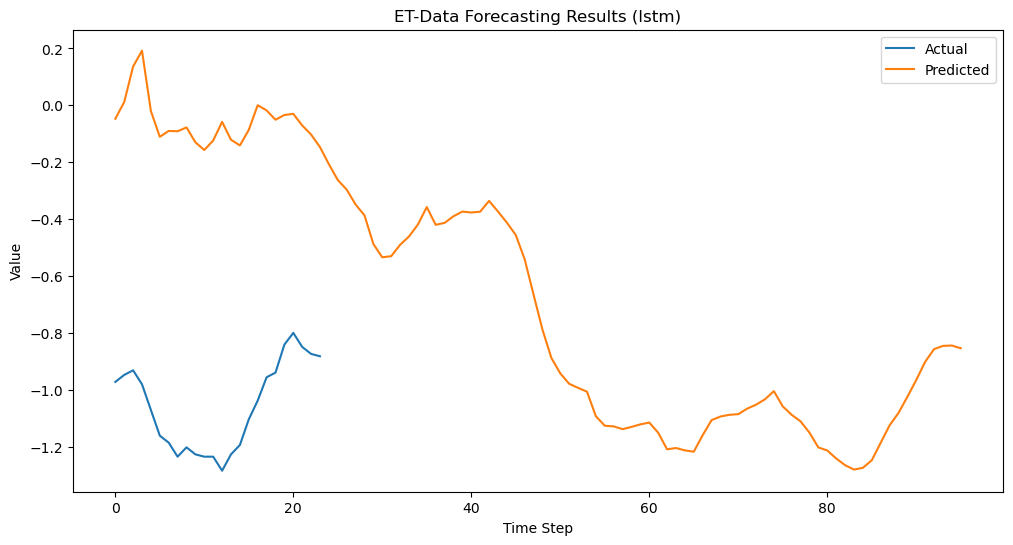

In [20]:
# Plot results
plt.figure(figsize=(12, 6))
plt.plot(actuals[0, :, 0], label='Actual')
plt.plot(predictions[0, :, 0], label='Predicted')
plt.title(f'ET-Data Forecasting Results ({config["model"]["type"]})')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()

## 5. Comparing Different Models

Let's train and compare different models on the ET-data.


Training lstm model...
Epoch [1/50] - Train Loss: 0.7041 | Valid Loss: 0.4020
Epoch [2/50] - Train Loss: 0.2875 | Valid Loss: 0.1886
Epoch [3/50] - Train Loss: 0.1825 | Valid Loss: 0.1563
Epoch [4/50] - Train Loss: 0.1144 | Valid Loss: 0.0977
Epoch [5/50] - Train Loss: 0.0901 | Valid Loss: 0.0759
Epoch [6/50] - Train Loss: 0.0650 | Valid Loss: 0.0504
Epoch [7/50] - Train Loss: 0.0481 | Valid Loss: 0.0476
Epoch [8/50] - Train Loss: 0.0350 | Valid Loss: 0.0276
Epoch [9/50] - Train Loss: 0.0254 | Valid Loss: 0.0229
Epoch [10/50] - Train Loss: 0.0411 | Valid Loss: 0.0491
Epoch [11/50] - Train Loss: 0.0237 | Valid Loss: 0.0163
Epoch [12/50] - Train Loss: 0.0149 | Valid Loss: 0.0134
Epoch [13/50] - Train Loss: 0.0125 | Valid Loss: 0.0149
Epoch [14/50] - Train Loss: 0.0114 | Valid Loss: 0.0103
Epoch [15/50] - Train Loss: 0.0097 | Valid Loss: 0.0084
Epoch [16/50] - Train Loss: 0.0095 | Valid Loss: 0.0082
Epoch [17/50] - Train Loss: 0.0457 | Valid Loss: 0.0152
Epoch [18/50] - Train Loss: 0.011

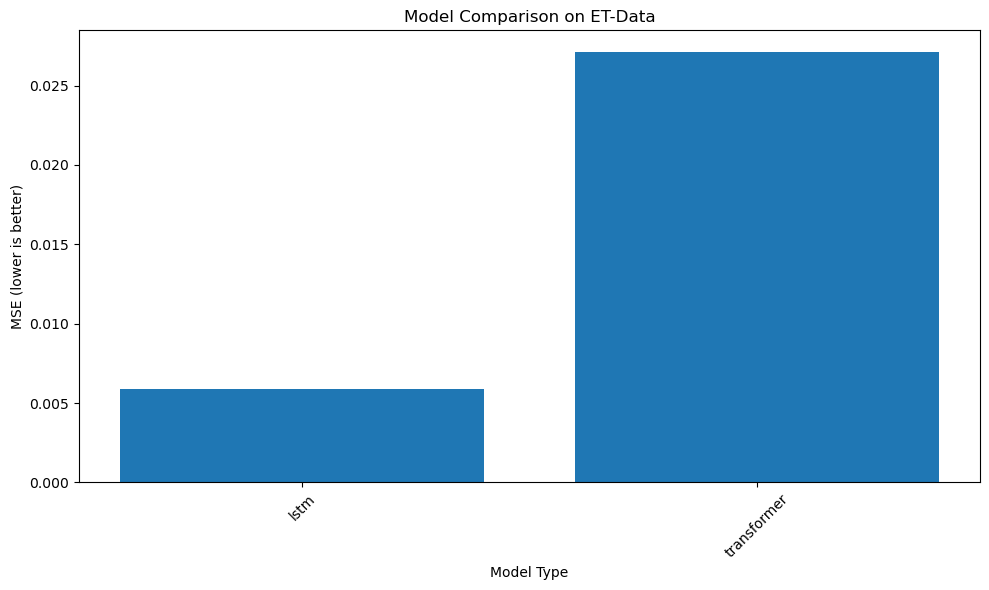

In [21]:
# List of models to compare
model_types = ['lstm', 'transformer']
results = {}

for model_type in model_types:
    print(f"\nTraining {model_type} model...")

    # Update config
    config['model']['type'] = model_type

    # Train model
    model = train_model(
        train_loader=train_loader,
        valid_loader=valid_loader,
        input_dim=input_dim,
        output_dim=output_dim,
        seq_len=seq_len,
        pred_len=pred_len,
        hidden_dim=config['model']['hidden_dim'],
        num_layers=config['model']['num_layers'],
        epochs=config['training']['epochs'],
        lr=config['training']['learning_rate'],
        patience=config['training']['patience'],
        device=config['training']['device'],
        model_type=model_type
    )

    # Evaluate model
    mse = evaluate_model(model, test_loader, device=config['training']['device'], model_type=model_type)
    results[model_type] = mse
    print(f"{model_type} Test MSE: {mse:.4f}")
    
    # Save model
    model_path = f"saved_models/et_{model_type}_model.pth"
    torch.save(model.state_dict(), model_path)
    print(f"Model saved to {model_path}")

# Plot comparison
plt.figure(figsize=(10, 6))
plt.bar(results.keys(), results.values())
plt.title('Model Comparison on ET-Data')
plt.xlabel('Model Type')
plt.ylabel('MSE (lower is better)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## 6. Hyperparameter Tuning

Let's experiment with different hyperparameters for the best model.

In [ ]:
# Find the best model
best_model = min(results, key=results.get)
print(f"Best model: {best_model} with MSE: {results[best_model]:.4f}")

# Hyperparameters to tune
hidden_dims = [64, 128, 256]
num_layers_list = [1, 2, 3]
learning_rates = [0.001, 0.0005, 0.0001]

# You can choose which hyperparameters to tune
param_name = 'hidden_dim'  # Options: 'hidden_dim', 'num_layers', 'learning_rate'
param_values = hidden_dims if param_name == 'hidden_dim' else num_layers_list if param_name == 'num_layers' else learning_rates

tuning_results = {}

for value in param_values:
    print(f"Tuning {param_name} = {value}...")
    
    # Update config
    if param_name == 'hidden_dim':
        config['model']['hidden_dim'] = value
    elif param_name == 'num_layers':
        config['model']['num_layers'] = value
    elif param_name == 'learning_rate':
        config['training']['learning_rate'] = value
    
    # Train model
    model = train_model(
        train_loader=train_loader,
        valid_loader=valid_loader,
        input_dim=input_dim,
        output_dim=output_dim,
        seq_len=seq_len,
        pred_len=pred_len,
        hidden_dim=config['model']['hidden_dim'],
        num_layers=config['model']['num_layers'],
        epochs=config['training']['epochs'],
        lr=config['training']['learning_rate'],
        patience=config['training']['patience'],
        device=config['training']['device'],
        model_type=best_model
    )
    
    # Evaluate model
    mse = evaluate_model(model, test_loader, device=config['training']['device'], model_type=best_model)
    tuning_results[value] = mse
    print(f"Test MSE: {mse:.4f}")

# Plot tuning results
plt.figure(figsize=(10, 6))
plt.plot(list(tuning_results.keys()), list(tuning_results.values()), marker='o')
plt.title(f'Tuning {param_name} for {best_model} Model')
plt.xlabel(param_name)
plt.ylabel('MSE (lower is better)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Find best hyperparameter
best_param = min(tuning_results, key=tuning_results.get)
print(f"Best {param_name}: {best_param} with MSE: {tuning_results[best_param]:.4f}")

## 7. Conclusion

In this notebook, we've:
1. Loaded and preprocessed the ET-data
2. Trained different models on the data
3. Evaluated and visualized the results
4. Compared different model architectures
5. Tuned hyperparameters for the best model

You can now use the best model and hyperparameters for your time series forecasting tasks.